# <center> Дипломный проект <br> Прогнозирование временных рядов трафика желтого такси Нью-Йорка

## <center>6 Дополнительные признаки <br>

На этой неделе нам предстоит попробовать добавить в регрессионную модель дополнительные признаки.

### Загрузка модулей

In [1]:
import os
from glob import glob
import itertools
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model, ensemble,metrics,neighbors
from scipy import stats
from tqdm import tqdm_notebook
import pickle
import holidays
#import xgboost
from sklearn.preprocessing import StandardScaler,MinMaxScaler

/home/mycacu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

На прошлой недели я использовал признаки:
- идентификатор географической зоны — категориальный
- год, месяц, день месяца, день недели, час — категориальный
- синусы, косинусы и тренды
- количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$
- количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}, \dots, y_{T-24*K_d}$
- суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
- индикатор праздников

Значения прогнозов ARIMA не использовал. Синусы, косинусы и тренды в этот раз использовать не буду, смысла в них для RandomForest нет.

#### Дополнительные признаки

Я добавил следующие признаки:
- средняя длительность поездок
- среднее количество пассажиров
- среднее расстояние по счётчику
- количество завершенных поездок

Новая функция обрабатывающая сырые данные (весь процесс обработки в другом notebook):

In [3]:
def prepare_file(path_file):
    #2015-16
    date_month = pd.to_datetime(path_file[-11:-4])    
    raw_data = pd.read_csv(path_file, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
    # Долгота
    xmin = -74.25559
    xmax = -73.70001
    # Широта
    ymin = 40.49612
    ymax = 40.91553

    raw_data = raw_data[['tpep_pickup_datetime','tpep_dropoff_datetime',
                         'passenger_count','trip_distance',
                         'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_amount']]
    raw_data['duration_trip'] = raw_data['tpep_dropoff_datetime'] - raw_data['tpep_pickup_datetime']
    
    pickup_data = raw_data
    dropoff_data = raw_data
    
    pickup_data = pickup_data[
        (pickup_data['tpep_dropoff_datetime'] != pickup_data['tpep_pickup_datetime']) & 
        (pickup_data['passenger_count'] != 0) &
        (pickup_data['trip_distance'] != 0) &
        (pickup_data['pickup_longitude'] >= xmin) &
        (pickup_data['pickup_longitude'] <= xmax) &
        (pickup_data['pickup_latitude'] >= ymin) &
        (pickup_data['pickup_latitude'] <= ymax)]
    
    dropoff_data = dropoff_data[
        (dropoff_data['tpep_dropoff_datetime'] != dropoff_data['tpep_pickup_datetime']) & 
        (dropoff_data['passenger_count'] != 0) &
        (dropoff_data['trip_distance'] != 0)]
    # Удаляем секунды и минуты
    pickup_data['tpep_pickup_datetime'] = pickup_data['tpep_pickup_datetime'] - \
    pd.to_timedelta(pickup_data.tpep_pickup_datetime.dt.second, unit='s') - \
    pd.to_timedelta(pickup_data.tpep_pickup_datetime.dt.minute, unit='m')
    
    dropoff_data['tpep_dropoff_datetime'] = dropoff_data['tpep_dropoff_datetime'] - \
    pd.to_timedelta(dropoff_data.tpep_dropoff_datetime.dt.second, unit='s') - \
    pd.to_timedelta(dropoff_data.tpep_dropoff_datetime.dt.minute, unit='m')
    # Добавляем регион
    pickup_data['region'] = region(pickup_data['pickup_longitude'].values,pickup_data['pickup_latitude'].values)
    dropoff_data['region'] = region(dropoff_data['dropoff_longitude'].values,dropoff_data['dropoff_latitude'].values)
    #dropoff_data.loc[:,'region_pickup'] = region(dropoff_data['pickup_longitude'].values,dropoff_data['pickup_latitude'].values)
    #dropoff_data = dropoff_data[(dropoff_data.region != dropoff_data.region_pickup)]
    pickup_data['pickup_trips'] = 0
    dropoff_data['dropoff_trips'] = 0
    # Группируем и подсчитываем количество элементов в группах
    pickup_data.duration_trip = pickup_data.duration_trip.astype('timedelta64[s]')    
    pickup_group = pickup_data.groupby(by=['tpep_pickup_datetime','region'], as_index=False)
    dropoff_group = dropoff_data.groupby(by=['tpep_dropoff_datetime','region'], as_index=False)
    pickup_trips = pickup_group.pickup_trips.count()
    dropoff_trips = dropoff_group.dropoff_trips.count()
    duration_trips = pickup_group.duration_trip.mean()
    passenger_count = pickup_group.passenger_count.mean()
    distance_trips = pickup_group.trip_distance.mean()
    pickup_trips['prop_trips'] = pickup_trips.apply(lambda x: x['pickup_trips'] / 
                                                    pickup_trips.loc[pickup_trips.tpep_pickup_datetime == x['tpep_pickup_datetime'],'pickup_trips'].sum(),axis=1)
    # Создаем пустой месяц по всем регионам
    month = []
    for t in pd.date_range(start=date_month, end=date_month + DateOffset(months=1),freq='H',closed='left'):
        for i in range(1,2501):
            month.append([t,i])
    month = pd.DataFrame(month, columns=['datetime','region'])
    
    train_data = pd.merge(month,pickup_trips,left_on=['datetime','region'], right_on=['tpep_pickup_datetime','region'],how='left')
    train_data = pd.merge(train_data,dropoff_trips,left_on=['datetime','region'], right_on=['tpep_dropoff_datetime','region'],how='left')
    train_data = pd.merge(train_data,duration_trips,left_on=['datetime','region'], right_on=['tpep_pickup_datetime','region'],how='left')
    train_data = pd.merge(train_data,passenger_count,left_on=['datetime','region'], right_on=['tpep_pickup_datetime','region'],how='left')
    train_data = pd.merge(train_data,distance_trips,left_on=['datetime','region'], right_on=['tpep_pickup_datetime','region'],how='left')
    train_data = train_data[['datetime','region','pickup_trips','dropoff_trips','duration_trip','passenger_count','trip_distance']]
    train_data.fillna(0,inplace=True)
    train_data[['region','pickup_trips','dropoff_trips']] = train_data[['region','pickup_trips','dropoff_trips']].astype(int)
    train_data.to_csv(path_or_buf = 'train_data_' + date_month.strftime("%Y-%m") + '.csv', index=False)

Загрузим обработанные такие способом данные

In [3]:
with open('data/data.pkl','rb') as f:
    data = pickle.load(f)
with open('data/list_region.pkl','rb') as f:
    list_region = pickle.load(f)

В итоге получилась такая таблица:

In [4]:
data = data[data.datetime >= '2016']

In [7]:
print(f'Имеем данные с {min(data.datetime)} по {max(data.datetime)}')

Имеем данные с 2016-01-01 00:00:00 по 2016-06-30 23:00:00


### Модель на исходных признаках

Создадим выборки с признаками из прошлой недели:
- идентификатор географической зоны — категориальный
- год, месяц, день месяца, день недели, час — категориальный
- количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$
- количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}, \dots, y_{T-24*K_d}$
- суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
- индикатор праздников

In [48]:
times = pd.DatetimeIndex(data.datetime.unique())
us_holidays = holidays.US()
K = 24
K_d = 7
samples = []
for region in tqdm_notebook(list_region):
    sample = pd.DataFrame(index=times)
    sample['holiday'] = list(map(lambda x: x in us_holidays,times))
    sample['region'] = region
    #sample['region_x'] = region_xy(region)[0]
    #sample['region_y'] = region_xy(region)[1]
    sample['year'] = times.year
    sample['month'] = times.month
    sample['weekday'] = times.weekday
    sample['hour'] = times.hour
    for i in range(K):
        sample[f'{i}_hours_ago'] = data.loc[data.region == region, 'pickup_trips'].shift(i).values
    for i in range(1, K_d+1):
        sample[f'{i*24}_hours_ago'] = data.loc[data.region == region, 'pickup_trips'].shift(i*24).values
    sample['total_trips_half-day'] = data.loc[data.region == region, 'pickup_trips'].rolling(12).sum().values
    sample['total_trips_day'] = data.loc[data.region == region, 'pickup_trips'].rolling(24).sum().values
    sample['total_trips_week'] = data.loc[data.region == region, 'pickup_trips'].rolling(168).sum().values
    for i in range(1,7):
        sample[f'target_{i}'] = data.loc[data.region == region, 'pickup_trips'].shift(-i).values
    samples.append(sample.dropna())
samples = pd.concat(samples)

In [30]:
def region_xy(region):
    x = (regions.loc[region,'west'] - regions.loc[region,'east']) / 2 + regions.loc[region,'east']
    y = (regions.loc[region,'south'] - regions.loc[region,'north']) / 2 + regions.loc[region,'north']
    return x, y

In [7]:
regions = pd.read_csv('data/regions.csv',sep=';',index_col='region')
regions.head()

,west,east,south,north
region,,,,
1,-74.25559,-74.244478,40.496120,40.504508
2,-74.25559,-74.244478,40.504508,40.512896
3,-74.25559,-74.244478,40.512896,40.521285
4,-74.25559,-74.244478,40.521285,40.529673
5,-74.25559,-74.244478,40.529673,40.538061


In [49]:
y_train = []
y_control = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.04.30 17:00']
X_control = samples.iloc[:,:-6]['2016.04.30 23:00':'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

И посчитаем ошибку на майских данных:

In [51]:
Q_control = []
for i in tqdm_notebook(range(6)):
    model = ensemble.RandomForestRegressor(random_state=1,n_estimators=20, 
                                           max_features=int(len(X_train.columns)/3)+1,n_jobs=-1)
    model.fit(X_train,y_train[i])
    predict = model.predict(X_control)        
    Q = metrics.mean_absolute_error(y_control[i], predict)
    Q_control.append(Q)
    
Q_control = sum(Q_control) / 6
print(f'Ошибка прогноза: {Q_control:.1f}')


Ошибка прогноза: 19.6


Посмотрим на важность признаков:

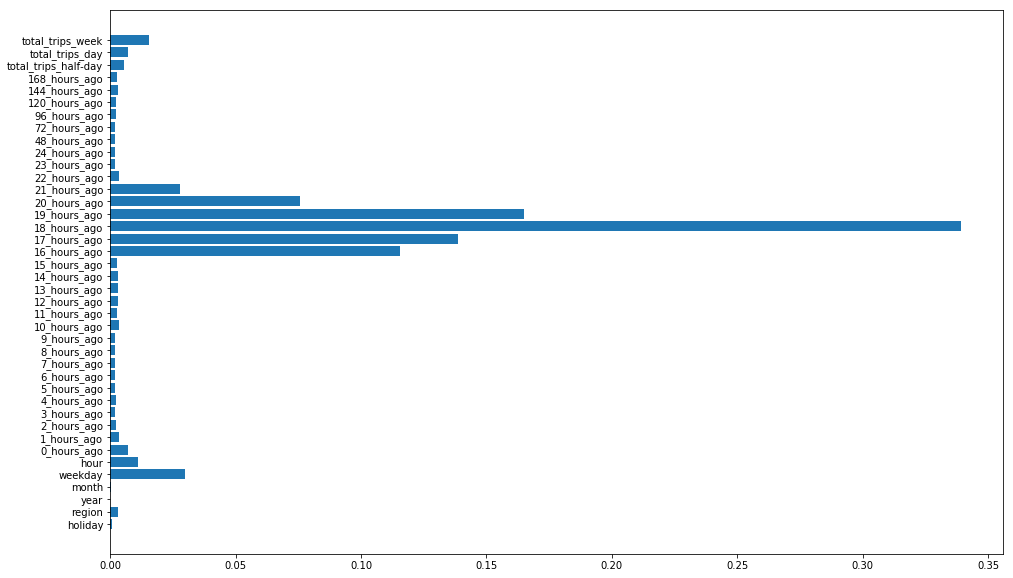

In [52]:
plt.figure(figsize=(16,10))
plt.barh(X_train.columns, model.feature_importances_, align='center')
plt.show()

### Модель с дополнительными признаками

Теперь добавим признаки:
- средняя длительность поездок
- среднее количество пассажиров
- среднее расстояние по счётчику
- количество завершенных поездок в данный час
- количество завершенных поездок 24 часа назад

In [12]:
times = pd.DatetimeIndex(data.datetime.unique())
us_holidays = holidays.US()
K = 24
K_d = 7
samples = []
for region in tqdm_notebook(list_region):
    sample = pd.DataFrame(index=times)
    sample['holiday'] = list(map(lambda x: x in us_holidays,times))
    sample['dropoff'] = data.loc[data.region == region, 'dropoff_trips'].values
    sample['dropoff_24_hours_ago'] = data.loc[data.region == region, 'dropoff_trips'].shift(24).values
    sample['duration_trip'] = data.loc[data.region == region, 'duration_trip'].values
    sample['passenger_count'] = data.loc[data.region == region, 'passenger_count'].values
    sample['trip_distance'] = data.loc[data.region == region, 'trip_distance'].values
    sample['region'] = region
    sample['year'] = times.year
    sample['month'] = times.month
    sample['weekday'] = times.weekday
    sample['hour'] = times.hour
    for i in range(K):
        sample[f'{i}_hours_ago'] = data.loc[data.region == region, 'pickup_trips'].shift(i).values
    for i in range(1, K_d+1):
        sample[f'{i*24}_hours_ago'] = data.loc[data.region == region, 'pickup_trips'].shift(i*24).values
    sample['total_trips_half-day'] = data.loc[data.region == region, 'pickup_trips'].rolling(12).sum().values
    sample['total_trips_day'] = data.loc[data.region == region, 'pickup_trips'].rolling(24).sum().values
    sample['total_trips_week'] = data.loc[data.region == region, 'pickup_trips'].rolling(168).sum().values
    for i in range(1,7):
        sample[f'target_{i}'] = data.loc[data.region == region, 'pickup_trips'].shift(-i).values
    samples.append(sample.dropna())
samples = pd.concat(samples)

In [13]:
y_train = []
y_control = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.04.30 17:00']
X_control = samples.iloc[:,:-6]['2016.04.30 23:00':'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

Посчитаем ошибку на майских данных:

In [14]:
Q_control = []
for i in tqdm_notebook(range(6)):
    model = ensemble.RandomForestRegressor(random_state=1,n_estimators=100, 
                                           max_features=int(len(X_train.columns)/3)+1,n_jobs=-1)
    model.fit(X_train,y_train[i])
    predict = model.predict(X_control)        
    Q = metrics.mean_absolute_error(y_control[i], predict)
    Q_control.append(Q)
    
Q_control = sum(Q_control) / 6
print(f'Ошибка прогноза: {Q_control:.1f}')


Ошибка прогноза: 16.4


Ошибка уменьшилась на 0.3 :)

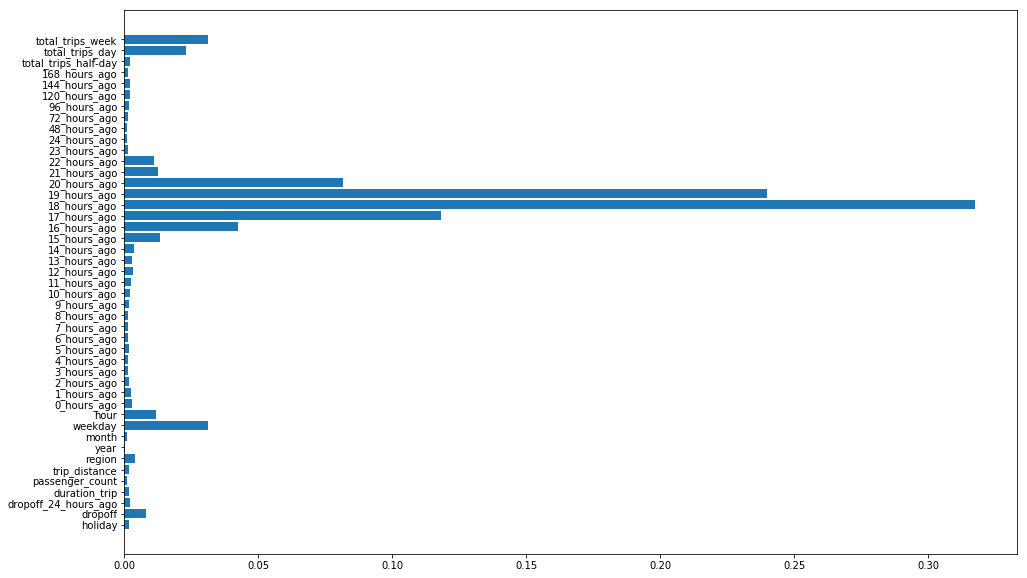

In [15]:
plt.figure(figsize=(16,10))
plt.barh(X_train.columns, model.feature_importances_, align='center')
plt.show()

Новые признаки вносят небольшой вклад

А теперь попробуем использовать количество завершенных поездок в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$

In [5]:
times = pd.DatetimeIndex(data.datetime.unique())
us_holidays = holidays.US()
K = 24
K_d = 7
K_drop = 25
samples = []
for region in tqdm_notebook(list_region):
    sample = pd.DataFrame(index=times)
    sample['holiday'] = list(map(lambda x: x in us_holidays,times))
    for i in range(K_drop):
        sample[f'{i}_hours_ago_dropoff'] = data.loc[data.region == region, 'dropoff_trips'].shift(i).values
    sample['duration_trip'] = data.loc[data.region == region, 'duration_trip'].values
    sample['passenger_count'] = data.loc[data.region == region, 'passenger_count'].values
    sample['trip_distance'] = data.loc[data.region == region, 'trip_distance'].values
    sample['region'] = region
    sample['year'] = times.year
    sample['month'] = times.month
    sample['weekday'] = times.weekday
    sample['hour'] = times.hour
    for i in range(K):
        sample[f'{i}_hours_ago'] = data.loc[data.region == region, 'pickup_trips'].shift(i).values
    for i in range(1, K_d+1):
        sample[f'{i*24}_hours_ago'] = data.loc[data.region == region, 'pickup_trips'].shift(i*24).values
    sample['total_trips_half-day'] = data.loc[data.region == region, 'pickup_trips'].rolling(12).sum().values
    sample['total_trips_day'] = data.loc[data.region == region, 'pickup_trips'].rolling(24).sum().values
    sample['total_trips_week'] = data.loc[data.region == region, 'pickup_trips'].rolling(168).sum().values
    for i in range(1,7):
        sample[f'target_{i}'] = data.loc[data.region == region, 'pickup_trips'].shift(-i).values
    samples.append(sample.dropna())
samples = pd.concat(samples)

In [6]:
y_train = []
y_control = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.04.30 17:00']
X_control = samples.iloc[:,:-6]['2016.04.30 23:00':'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.04.30 17:00'])
    y_control.append(samples.iloc[:,i]['2016.04.30 23:00':'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [ ]:
Q_control = []
for i in tqdm_notebook(range(6)):
    model = ensemble.RandomForestRegressor(random_state=1,n_estimators=100, 
                                           max_features=int(len(X_train.columns)/3)+1,n_jobs=-1)
    model.fit(X_train,y_train[i])
    predict = model.predict(X_control)        
    Q = metrics.mean_absolute_error(y_control[i], predict)
    Q_control.append(Q)
    
Q_control = sum(Q_control) / 6
print(f'Ошибка прогноза: {Q_control:.1f}')

Ошибка уменьшилась еще на 0.3 :)

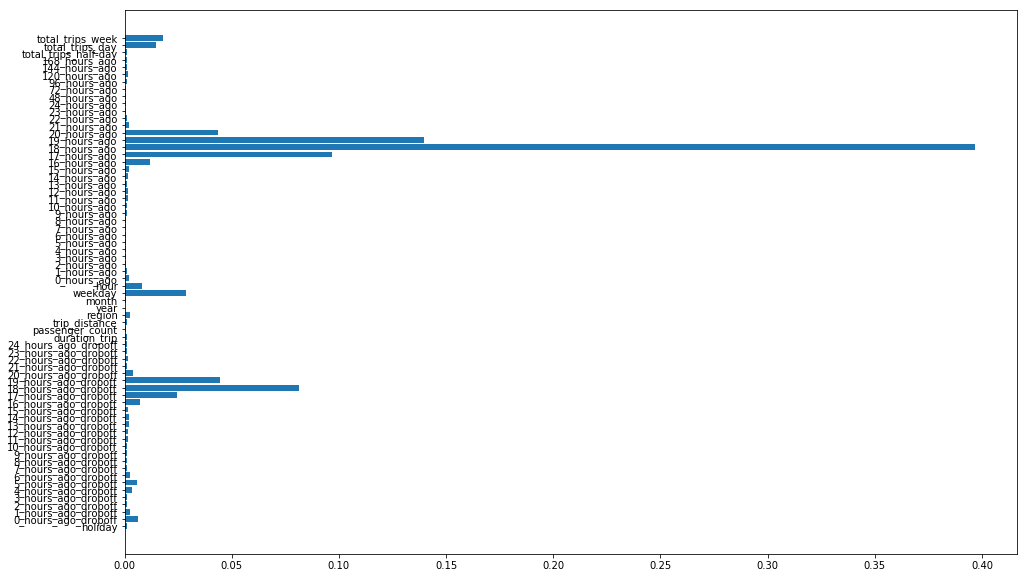

In [19]:
plt.figure(figsize=(16,10))
plt.barh(X_train.columns, model.feature_importances_, align='center')
plt.show()

### Прогноз на июнь

В итоге ошибка упала на 0.6.

Обучим модели на майских данных и сделаем прогноз на июнь:

In [24]:
y_train = []
y_test = []
X_train = samples.iloc[:,:-6][:'2016.05.31 17:00']
X_test = samples.iloc[:,:-6]['2016.05.31 23:00':'2016.06.30 17:00']

for i in range(-6,0):
    y_train.append(samples.iloc[:,i][:'2016.05.31 17:00'])
    y_test.append(samples.iloc[:,i]['2016.05.31 23:00':'2016.06.30 17:00'])

In [25]:
Q_test = []
predict_kaggle = []
regions = X_test.region.values
for i in tqdm_notebook(range(6)):
    model = ensemble.RandomForestRegressor(random_state=1,n_estimators=100, 
                                           max_features=int(len(X_train.columns)/3)+1,n_jobs=-1)
    model.fit(X_train,y_train[i])
    predict = model.predict(X_test)
        
    Q = metrics.mean_absolute_error(y_test[i], predict)
    Q_test.append(Q)
    
    for j,t in enumerate(X_test.index):
        region = regions[j]
        idx = '_'.join([str(int(region)),str(t.date()),str(t.hour),str(i+1)])
        y = str((predict[j]))
        answer = ','.join([idx, y])
        predict_kaggle.append(answer)
    
Q_test = sum(Q_test) / 6
print(f'Ошибка прогноза: {Q_test:.1f}')


Ошибка прогноза: 15.9


In [26]:
print('\n'.join(predict_kaggle[:10]))

1075_2016-05-31_23_1,23.92
1075_2016-06-01_0_1,15.88
1075_2016-06-01_1_1,8.3
1075_2016-06-01_2_1,4.18
1075_2016-06-01_3_1,4.56
1075_2016-06-01_4_1,8.99
1075_2016-06-01_5_1,20.14
1075_2016-06-01_6_1,47.82
1075_2016-06-01_7_1,72.53
1075_2016-06-01_8_1,65.64


In [27]:
with open('results.csv','w') as f:
    f.write('id,y\n')
    f.write('\n'.join(predict_kaggle))

На kaggle получилось score = 15.89617

Спасибо за внимание)